In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jaxinterp2d import interp2d

## 1. Generate data + pretraining

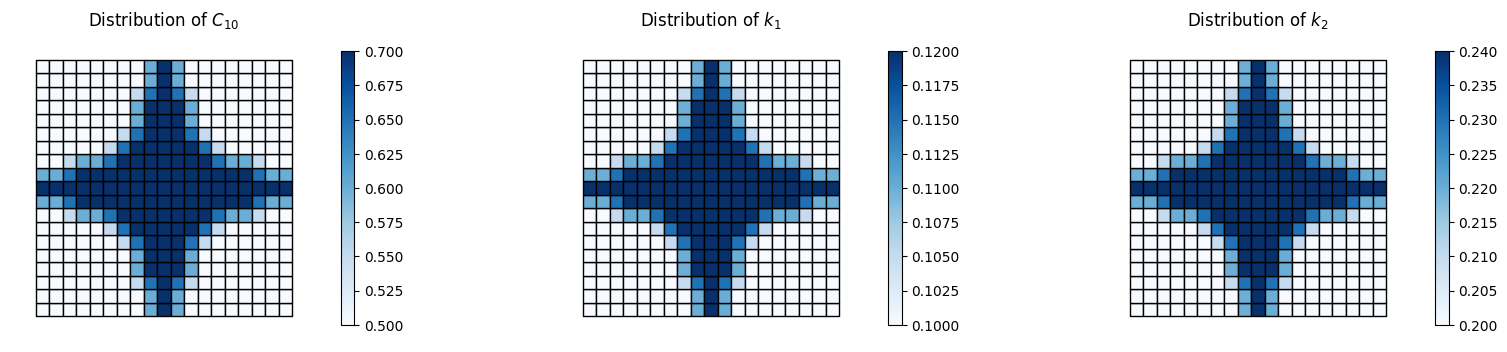

In [4]:
# Generate a synthetic heterogeneous field and assume some boundary conditions
nvar = 2
nrow = 20
ncol = 20
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
pts_x = np.linspace(0,1,nrow)
pts_y = np.linspace(0,1,ncol)
node_X, node_Y = np.meshgrid(pts_x,pts_y)
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

# Identify the boundary nodes
rgt_bd = np.where(node_X[:,0]>0.99)
top_bd = np.where(node_X[:,1]>0.99)
lft_bd = np.where(node_X[:,0]<0.01)
bot_bd = np.where(node_X[:,1]<0.01)
rgt_bd_x = node_X[rgt_bd,0].flatten()
rgt_bd_y = node_X[rgt_bd,1].flatten()
top_bd_x = node_X[top_bd,0].flatten()
top_bd_y = node_X[top_bd,1].flatten()
lft_bd_x = node_X[lft_bd,0].flatten()
lft_bd_y = node_X[lft_bd,1].flatten()
bot_bd_x = node_X[bot_bd,0].flatten()
bot_bd_y = node_X[bot_bd,1].flatten()

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

C10 = np.ones(n_node)*0.5
k1  = np.ones(n_node)*0.1
k2  = np.ones(n_node)*0.2

# Draw the star
l_1 = 1.2
l_2 = 0.3
vertices = np.array([[   0, l_1],
                     [ l_2, l_2],
                     [ l_1,   0],
                     [ l_2,-l_2],
                     [   0,-l_1],
                     [-l_2,-l_2],
                     [-l_1,   0],
                     [-l_2, l_2],
                     ])
vertices = (vertices + 1)/2 #I am drawing the star in the [-1,1] domain and transforming to [0,1]
polygon_path = Path(vertices)

for i in range(n_node):
    x = node_X[i, 0]
    y = node_X[i, 1]
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    if polygon_path.contains_point((x,y)):
        C10[i] = 0.7
        k1[i] = 0.12
        k2[i] = 0.24

fig, ax = plt.subplots(1,3,figsize=(20,4))
c_elem = 0.25*(C10[elements[:,0]] + C10[elements[:,1]] + C10[elements[:,2]] + C10[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $C_{10}$', ax=ax[0]); 
c_elem = 0.25*(k1[elements[:,0]] + k1[elements[:,1]] + k1[elements[:,2]] + k1[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $k_1$', ax=ax[1]); 
c_elem = 0.25*(k2[elements[:,0]] + k2[elements[:,1]] + k2[elements[:,2]] + k2[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $k_2$', ax=ax[2]); 

Fx = np.random.uniform()+0.5

In [5]:
class GOH_SEDF():
    def __init__(self):
        return
    
    def fiberangle(self, node_X):
        return 0.0
    
    def X2params(self, X):
        X_C10    = interp2d(X[0], X[1], pts_x, pts_y,   C10.reshape([nrow,ncol]))
        X_k1     = interp2d(X[0], X[1], pts_x, pts_y,    k1.reshape([nrow,ncol]))
        X_k2     = interp2d(X[0], X[1], pts_x, pts_y,    k2.reshape([nrow,ncol]))
        X_kappa  = 0.1
        return X_C10, X_k1, X_k2, X_kappa

    def Psi_i(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
        Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
        Psi2 = 0.0
        Psiw = 0.0
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi11 =          kappa**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psi1v = kappa*(1-3*kappa)*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psivv =    (1-3*kappa)**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)

        Psi12 = Psi22 = Psi1w = Psi2v = Psi2w = Psivw = Psiww = 0.0
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [6]:
mySEDF = GOH_SEDF()
const_model = vahid_anisohyper_inv(mySEDF)
node_x_hist_goh = []
F_hist_goh = []
sigma_hist_goh = []
node_x = np.copy(node_X)
lmb_hist = [1.05, 1.10, 1.15, 1.20]
t_hist = np.arange(len(lmb_hist))
l=h=1.0
for i in range(len(lmb_hist)):
    lmb = lmb_hist[i]
    node_x, DOF_fmap = apply_bc_biax(node_x, lmx=lmb, lmy=lmb, l0=l, h0=h)
    mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
    mysolver.n_print = 1
    mysolver.itermax = 20
    node_x, F, sigma = mysolver.solve()
    node_x_hist_goh.append(node_x)
    F_hist_goh.append(F)
    sigma_hist_goh.append(sigma)

    l=h=lmb
node_x_hist_goh = np.array(node_x_hist_goh)
F_hist_goh = np.array(F_hist_goh)
sigma_hist_goh = np.array(sigma_hist_goh)

Solving...
iter 1,   residual = 1.945254675342529
iter 2,   residual = 0.8738100324206425
iter 3,   residual = 0.28269506918389276
iter 4,   residual = 0.07448220698080042
iter 5,   residual = 0.0020955769821697457
iter 6,   residual = 0.00016296259838376493
iter 7,   residual = 1.3528004752674008e-05
iter 8,   residual = 1.127789701774223e-06
Solution converged!
Solving...
iter 1,   residual = 2.330426476602162
iter 2,   residual = 0.975979382341717
iter 3,   residual = 0.2675185686289516
iter 4,   residual = 0.046635432931536915
iter 5,   residual = 0.005733123616443687
iter 6,   residual = 0.0010086962271925563
iter 7,   residual = 0.00017244204263043016
iter 8,   residual = 2.9779854235926665e-05
iter 9,   residual = 5.154591315432038e-06
Solution converged!
Solving...
iter 1,   residual = 2.9054488985574567
iter 2,   residual = 1.1672742823996234
iter 3,   residual = 0.32114170379622003
iter 4,   residual = 0.05452614732185568
iter 5,   residual = 0.011365959861407244
iter 6,   re

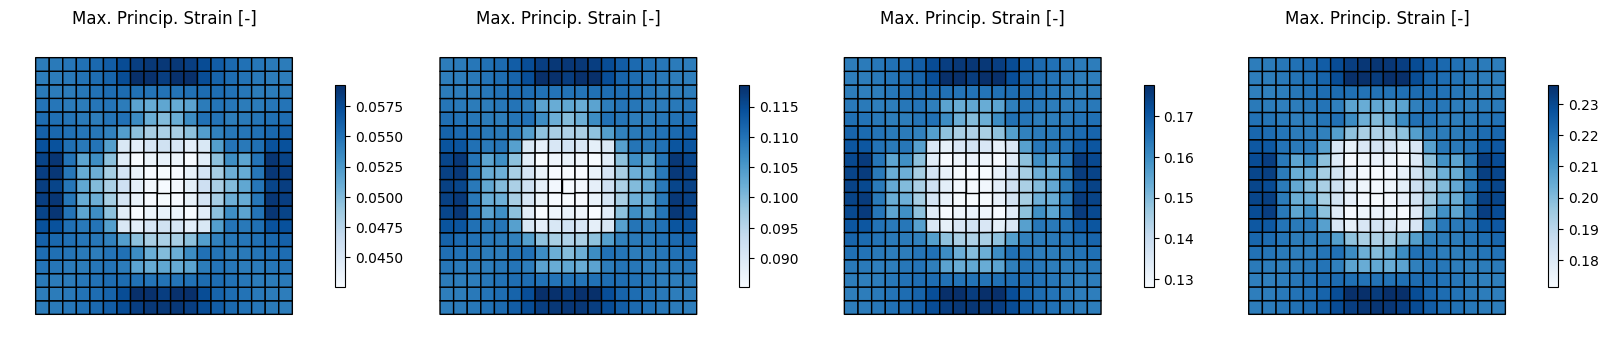

In [7]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist_goh, F_hist_goh, sigma_hist_goh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(elements, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

it 1000, train loss = 3.880497e-04
it 2000, train loss = 1.301186e-04
it 3000, train loss = 6.225361e-05
it 4000, train loss = 3.358877e-05
it 5000, train loss = 1.972397e-05
it 6000, train loss = 1.247682e-05
it 7000, train loss = 8.289590e-06
it 8000, train loss = 5.723229e-06
it 9000, train loss = 4.152304e-06
it 10000, train loss = 3.210395e-06
it 11000, train loss = 2.563011e-06
it 12000, train loss = 2.059056e-06
it 13000, train loss = 1.751386e-06
it 14000, train loss = 1.586480e-06
it 15000, train loss = 1.441644e-06
it 16000, train loss = 1.254633e-06
it 17000, train loss = 1.266519e-06
it 18000, train loss = 1.252160e-06
it 19000, train loss = 1.088178e-06
it 20000, train loss = 1.067342e-06
it 21000, train loss = 1.089240e-06
it 22000, train loss = 9.924339e-07
it 23000, train loss = 9.487303e-07
it 24000, train loss = 9.300437e-07
it 25000, train loss = 1.023703e-06
it 26000, train loss = 9.302064e-07
it 27000, train loss = 1.001667e-06
it 28000, train loss = 8.715103e-07
i

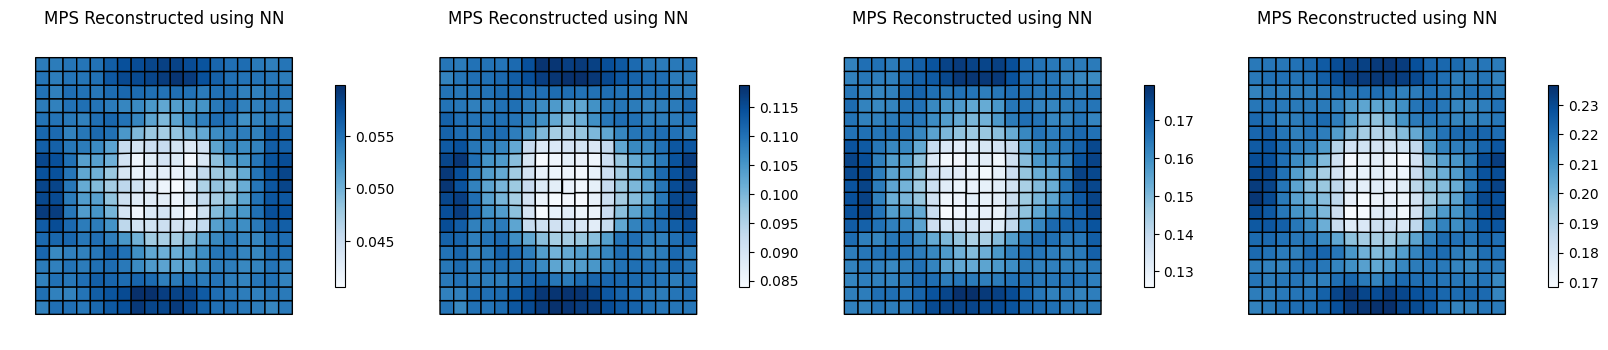

In [8]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = ff_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 20 # 10 cosines and 10 sines in the fourier features
n_inp = 3 # x, y, lmb
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])
nn_layers = [2*n_ff,20,20,2]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

element_x = np.array([np.mean(node_X[element][:,0]) for element in elements])
element_y = np.array([np.mean(node_X[element][:,1]) for element in elements])
element_X = np.array([element_x, element_y]).T
X = np.vstack([element_X, element_X, element_X, element_X])
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss, inp, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000, batch_size=1000)


fig, axes = plt.subplots(1,4,figsize=(20,4))
for t in t_hist:
    ax = axes[t]
    aux = np.hstack([element_X, t*np.ones_like(element_X[:,:1])])
    eps_xx_pr, eps_yy_pr = ff_nn(aux, coord_2_strain_params).T
    mps_pr = np.maximum(eps_xx_pr, eps_yy_pr)

    plotmesh(elements, node_x, mps_pr, title='MPS Reconstructed using NN', ax=ax); 

In [9]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(elements):
    if any([node_X[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([node_X[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([node_X[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([node_X[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(sigma_hist_goh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(sigma_hist_goh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(sigma_hist_goh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(sigma_hist_goh[:,bot_bd_elems,1,1], axis=1)
Fx = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Fy = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

# get the center points of the elements
elem_X = np.array([0.25*(node_X[e[0]] + node_X[e[1]] + node_X[e[2]] + node_X[e[3]]) for e in elements])
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [10]:
# Homogenize the strains
eps_xx_mean = np.mean(F_hist_goh[:,:,0,0]-1.0, axis=1)
eps_yy_mean = np.mean(F_hist_goh[:,:,1,1]-1.0, axis=1)
# eps_xy_mean = np.mean(0.5*(F_hist_goh[:,:,0,1]+F_hist_goh[:,:,1,0]), axis=1)
sgmx_mean = Fx/len(rgt_bd_elems)
sgmy_mean = Fy/len(top_bd_elems)
lamb_sigma_m = np.array([eps_xx_mean+1.0, eps_yy_mean+1.0, sgmx_mean, sgmy_mean]).reshape([len(lmb_hist),-1]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, key):
    model   = NODE_model_aniso(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sgmx_gt  = lamb_sigma[:,2]
    sgmy_gt  = lamb_sigma[:,3]
    sgm = eval_Cauchy_aniso_vmap(lambx,lamby, model)
    sgmx_pr, sgmy_pr = sgm[:,0,0], sgm[:,1,1]
    return np.mean((sgmx_pr-sgmx_gt)**2+(sgmy_pr-sgmy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000)

it 1000, train loss = 9.468046e-02
it 2000, train loss = 6.382703e-02
it 3000, train loss = 3.958042e-02
it 4000, train loss = 2.777438e-02
it 5000, train loss = 2.221905e-02
it 6000, train loss = 1.699769e-02
it 7000, train loss = 1.289677e-04
it 8000, train loss = 4.773719e-05
it 9000, train loss = 4.524114e-05
it 10000, train loss = 4.100008e-05


In [11]:
mymodel = NODE_model_aniso(node_params)
sgm = eval_Cauchy_aniso_vmap(eps_xx_mean+1.0,eps_yy_mean+1.0, mymodel)
sgmx, sgmy = sgm[:,0,0], sgm[:,1,1]
print('gt sgmx & sgmy: ', sgmx_mean, sgmy_mean)
print('pr sgmx & sgmy: ', sgmx, sgmy)

gt sgmx & sgmy:  [0.32733864 0.6232829  0.89895203 1.16276511] [0.31501079 0.59451977 0.84898892 1.08597333]
pr sgmx & sgmy:  [0.32656079 0.63073497 0.90109372 1.15723868] [0.30731838 0.59358047 0.84812725 1.08942814]


In [12]:
# Fit and pretrain a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = node_params
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights
params_I1c,params_I1s = params_I1
params_I2c,params_I2s = params_I2
params_1_vc,params_1_vs = params_1_v
params_1_wc,params_1_ws = params_1_w
params_v_wc,params_v_ws = params_v_w
sparams = (params_I1s, params_I2s, params_1_vs, params_1_ws, params_v_ws, theta, Psi1_bias, Psi2_bias, alpha)
phi, unravel = ravel_pytree(sparams)
n_phi = len(phi) #26

def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,30,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 2000, print_freq=1000)

it 1000, train loss = 1.432198e-03
it 2000, train loss = 4.194650e-04


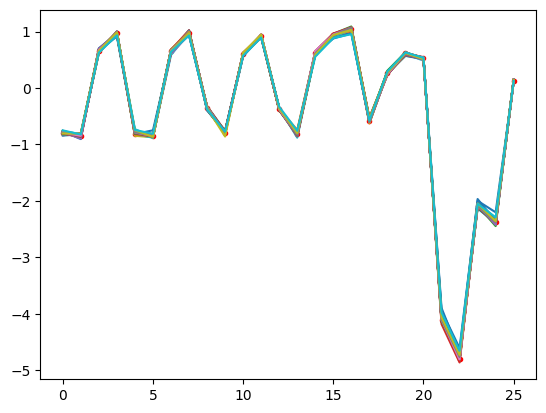

In [13]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [14]:
with open('params/star_multistep_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, sparams, Lambda_params, node_X, elements, n_node, Fx, Fy, strains,
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist], f)

## 2. Retrain

In [2]:
with open('params/star_multistep_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, sparams, Lambda_params, node_X, elements, n_node, Fx, Fy, strains, \
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist = pickle.load(f)
_, unravel = ravel_pytree(sparams)
NODE = lambda sparams: NODE_model_aniso(merge_weights_aniso(node_params, unravel(sparams)))

In [17]:
# Train
@jit
def loss(Lambda_params, X):
    div_x, div_y = divergence(Lambda_params, X, bd_X, coord_2_strain_params, NODE)
    F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, X, bd_X, coord_2_strain_params, NODE)
    t = X[1] # a scalar
    fx = Fx[jnp.array(t, int)]
    fy = Fy[jnp.array(t, int)]
    return a1*(div_x**2 + div_y**2) + a2*((F_rgt-fx)**2 + (F_top-fy)**2 + (F_lft-fx)**2 + (F_bot-fy)**2)

sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

metric1 = lambda params, X:  bd_forces(params, X, bd_X, coord_2_strain_params, NODE)
metric2 = lambda params, X: divergence(params, X, bd_X, coord_2_strain_params, NODE)

Lambda_params, val_loss, metrics = train_colloc(loss, [node_X, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 50000, print_freq=1000, metric_fns=[metric1, metric2])

with open('params/star_multistep_post.npy', 'wb') as f:
    pickle.dump([node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics], f)

it 1000, val loss = 1.020148e+00
it 2000, val loss = 2.573041e+00
it 3000, val loss = 2.417079e+00
it 4000, val loss = 5.582161e-01
it 5000, val loss = 2.221102e+00
it 6000, val loss = 6.827394e-01
it 7000, val loss = 1.815085e+00
it 8000, val loss = 1.157998e+00
it 9000, val loss = 9.086495e-01
it 10000, val loss = 1.784759e+00
it 11000, val loss = 1.064063e+00
it 12000, val loss = 2.425101e+00
it 13000, val loss = 1.296592e+00
it 14000, val loss = 2.365920e+00
it 15000, val loss = 2.208404e+00
it 16000, val loss = 1.364260e+00
it 17000, val loss = 2.217404e+00
it 18000, val loss = 2.287324e+00
it 19000, val loss = 1.583978e+00
it 20000, val loss = 1.954046e+00
it 21000, val loss = 1.622086e+00
it 22000, val loss = 1.891418e+00
it 23000, val loss = 2.073169e+00
it 24000, val loss = 2.430930e+00
it 25000, val loss = 2.115586e+00
it 26000, val loss = 1.839282e+00
it 27000, val loss = 2.040823e+00
it 28000, val loss = 2.513454e+00
it 29000, val loss = 2.250885e+00
it 30000, val loss = 2.

## 3. Test

In [3]:
with open('params/star_multistep_post.npy', 'rb') as f:
    node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics = pickle.load(f)

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_19473/3260991309.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  forces, div = np.array(metrics).T


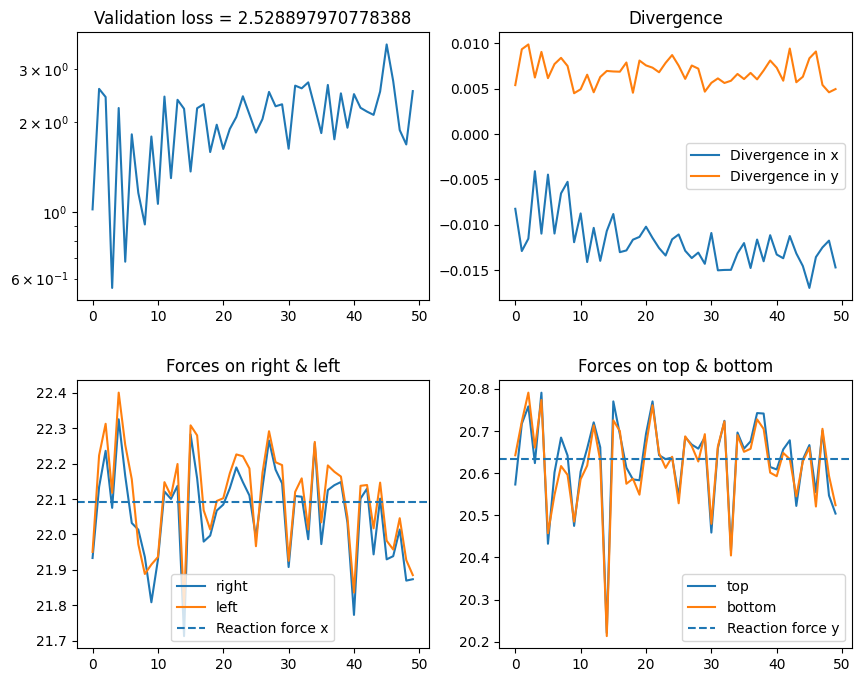

In [4]:
forces, div = np.array(metrics).T
forces = np.array([*forces])
div = np.array([*div])

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(val_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx[-1], linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy[-1], linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Validation loss = ' + str(val_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

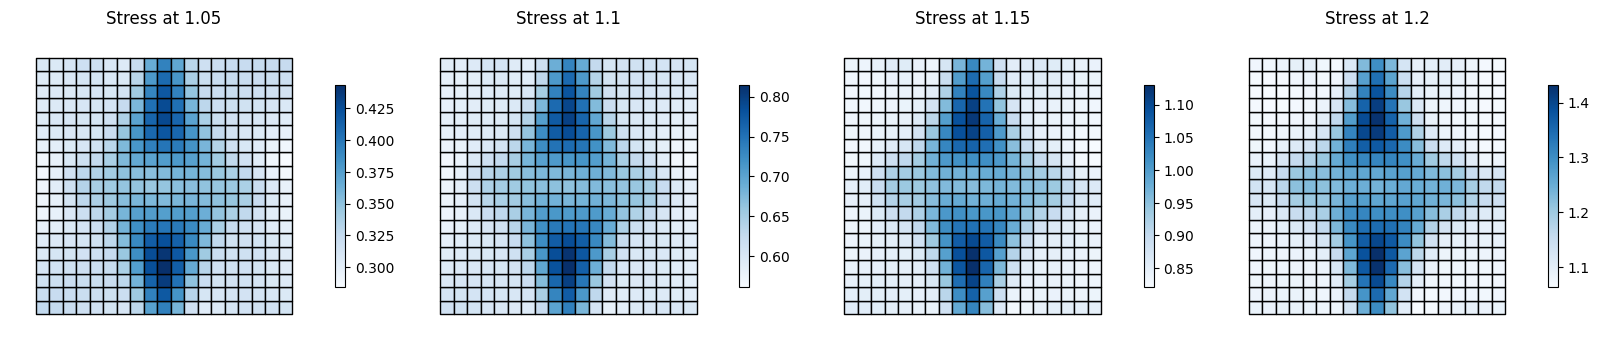

In [5]:
# Stiffness across the domain
fig, axes = plt.subplots(1,4,figsize=(20,4))
for lmb, ax in zip(lmb_hist, axes):
    sgm_list = []
    for x, y in node_X:
        Lambda_inp = jnp.array([x,y]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE(phi)
        sgm = eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0]
        sgm_list.append(sgm)
    sgm_list = np.array(sgm_list)
    c_elem = 0.25*(sgm_list[elements[:,0]] + 
                   sgm_list[elements[:,1]] + 
                   sgm_list[elements[:,2]] + 
                   sgm_list[elements[:,3]])
    plotmesh(elements, node_X, c_elem, title='Stress at {}'.format(str(lmb)), ax=ax); 

In [6]:
class NODE_SEDF_aniso():
    def __init__(self, Lambda_params=None, unravel=None):
        self.Lambda_params = Lambda_params
        self.unravel = unravel
        return
    def X2params(self, X):
        Lambda_inp = np.array([X[0],X[1]]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, self.Lambda_params).flatten()
        params = merge_weights_aniso(node_params, self.unravel(phi))
        return params
    def fiberangle(self, node_X):
        return 0.0
    
    def Psi_i(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        Psi1 = model.Psi1(I1,I2,Iv,Iw)
        Psi2 = model.Psi2(I1,I2,Iv,Iw)
        Psiv = model.Psiv(I1,I2,Iv,Iw)
        Psiw = model.Psiw(I1,I2,Iv,Iw)
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        
        e = 1.0e-6
        Psi1_p = model.Psi1(I1+e,I2,Iv,Iw)
        Psi1_m = model.Psi1(I1-e,I2,Iv,Iw)
        Psi2_p = model.Psi2(I1+e,I2,Iv,Iw)
        Psi2_m = model.Psi2(I1-e,I2,Iv,Iw)
        Psiv_p = model.Psiv(I1+e,I2,Iv,Iw)
        Psiv_m = model.Psiv(I1-e,I2,Iv,Iw)
        Psiw_p = model.Psiw(I1+e,I2,Iv,Iw)
        Psiw_m = model.Psiw(I1-e,I2,Iv,Iw)
        Psi11 = (Psi1_p-Psi1_m)/2/e
        Psi12 = (Psi2_p-Psi2_m)/2/e
        Psi1v = (Psiv_p-Psiv_m)/2/e
        Psi1w = (Psiw_p-Psiw_m)/2/e

        Psi2_p = model.Psi2(I1,I2+e,Iv,Iw)
        Psi2_m = model.Psi2(I1,I2-e,Iv,Iw)
        Psiv_p = model.Psiv(I1,I2+e,Iv,Iw)
        Psiv_m = model.Psiv(I1,I2-e,Iv,Iw)
        Psiw_p = model.Psiw(I1,I2+e,Iv,Iw)
        Psiw_m = model.Psiw(I1,I2-e,Iv,Iw)
        Psi22 = (Psi2_p-Psi2_m)/2/e
        Psi2v = (Psiv_p-Psiv_m)/2/e
        Psi2w = (Psiw_p-Psiw_m)/2/e

        Psiv_p = model.Psiv(I1,I2,Iv+e,Iw)
        Psiv_m = model.Psiv(I1,I2,Iv-e,Iw)
        Psiw_p = model.Psiw(I1,I2,Iv+e,Iw)
        Psiw_m = model.Psiw(I1,I2,Iv-e,Iw)
        Psivv = (Psiv_p-Psiv_m)/2/e
        Psivw = (Psiw_p-Psiw_m)/2/e

        Psiw_p = model.Psiw(I1,I2,Iv,Iw+e)
        Psiw_m = model.Psiw(I1,I2,Iv,Iw-e)
        Psiww = (Psiw_p-Psiw_m)/2/e
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [7]:
mySEDF = NODE_SEDF_aniso(Lambda_params, unravel)
const_model = vahid_anisohyper_inv(mySEDF)
node_x_hist = []
F_hist = []
sigma_hist = []
node_x = np.copy(node_X)
l=h=1.0
for i in range(len(lmb_hist)):
    lmb = lmb_hist[i]
    node_x, DOF_fmap = apply_bc_biax(node_x, lmx=lmb, lmy=lmb, l0=l, h0=h)
    mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
    mysolver.n_print = 1
    mysolver.itermax = 20
    mysolver.tol = 1e-3
    node_x, F, sigma = mysolver.solve()
    node_x_hist.append(node_x)
    F_hist.append(F)
    sigma_hist.append(sigma)

    l=h=lmb
node_x_hist = np.array(node_x_hist)
F_hist      = np.array(F_hist)
sigma_hist  = np.array(sigma_hist)

Solving...
iter 1,   residual = 10.461016954494694
iter 2,   residual = 2.9351860199193514
iter 3,   residual = 1.1183503849019447
iter 4,   residual = 0.42658794285870033
iter 5,   residual = 0.12305935070924567
iter 6,   residual = 0.023602515811672657
iter 7,   residual = 0.019483466820237057
iter 8,   residual = 0.011745369149282248
iter 9,   residual = 0.007500009816225298
iter 10,   residual = 0.004597834396510033
iter 11,   residual = 0.0030325793020594917
iter 12,   residual = 0.0018951560987963431
iter 13,   residual = 0.0012677100846394881
iter 14,   residual = 0.0008047724809322127
Solution converged!
Solving...
iter 1,   residual = 17.235779626452103
iter 2,   residual = 4.169810413325404
iter 3,   residual = 1.421954037116378
iter 4,   residual = 0.5725544183492003
iter 5,   residual = 0.20356509377730925
iter 6,   residual = 0.03253617012654683
iter 7,   residual = 0.011478110778615342
iter 8,   residual = 0.005702009712491827
iter 9,   residual = 0.0029927630130944386
it

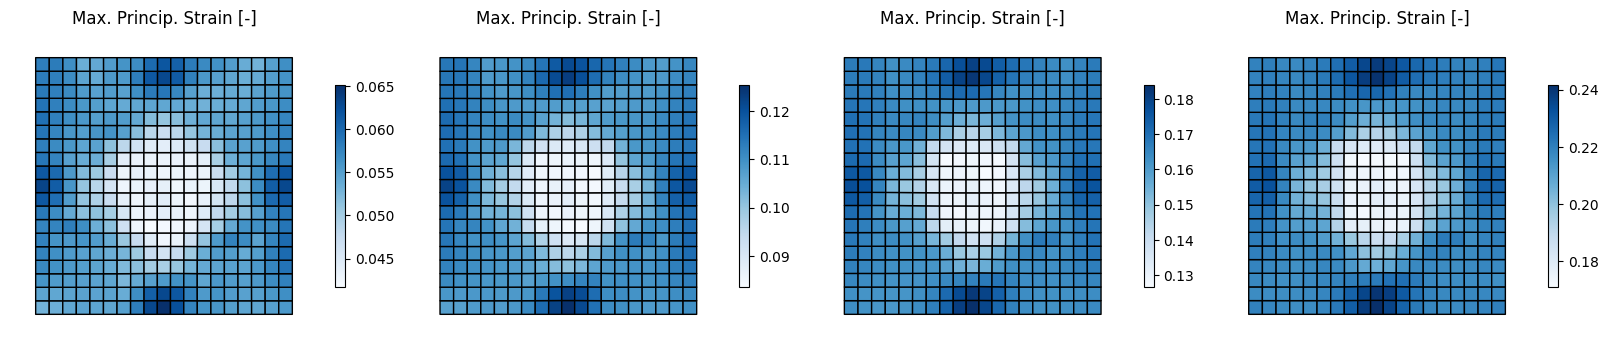

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(elements, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

In [9]:
with open('params/star_multistep_fem.npy', 'wb') as f:
    pickle.dump([node_X, t_hist, node_x_hist, F_hist, sigma_hist], f)